In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import RobustScaler, LabelEncoder, LabelBinarizer
import string
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.metrics import f1_score
import wandb
import random
from sklearn.metrics import confusion_matrix
print("Torch version:", torch.__version__)


Torch version: 2.2.2


In [2]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: felix-wdn (felix-organisation). Use `wandb login --relogin` to force relogin


True

In [4]:
sign_train = pd.read_csv("./data/sign_mnist_train.csv")
sign_test = pd.read_csv("./data/sign_mnist_test.csv")

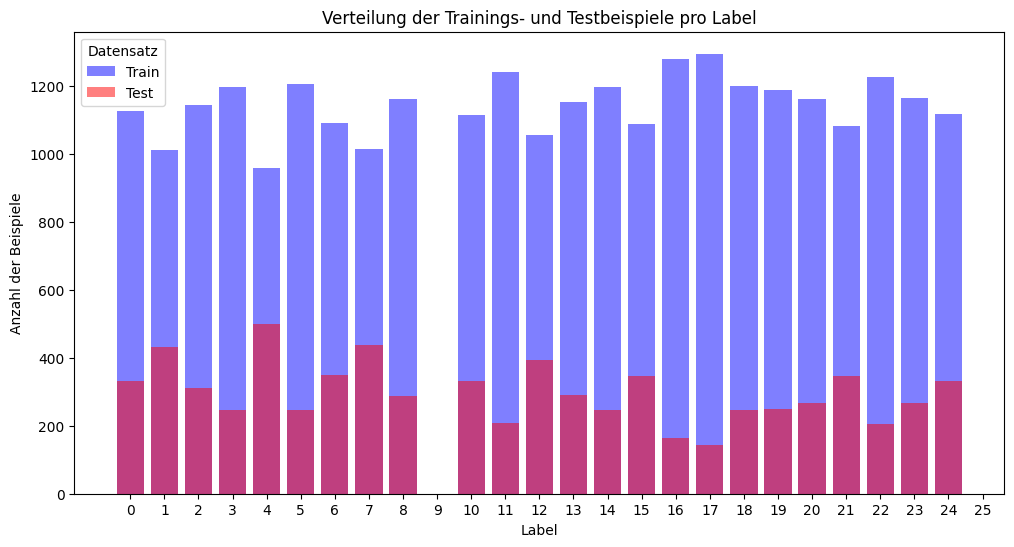

In [5]:
#Visualize Examples per Label in Training- and Test-Dataset
train_counts = sign_train['label'].value_counts().sort_index()
test_counts = sign_test['label'].value_counts().sort_index()

labels = list(set(sign_train["label"]))

plt.figure(figsize=(12, 6))

plt.bar(labels, train_counts, alpha=0.5, color='b', label='Train')
plt.bar(labels, test_counts, alpha=0.5, color='r', label='Test')

plt.title('Verteilung der Trainings- und Testbeispiele pro Label')
plt.xlabel('Label')
plt.ylabel('Anzahl der Beispiele')
plt.xticks(ticks= np.arange(26), labels=np.arange(26))
plt.legend(title='Datensatz')

plt.show()

In [6]:
#Each training and test case represents a label (0-25) as a one-to-one map for each alphabetic letter A-Z (and no cases for 9=J or 25=Z because of gesture motions)
labelAsLetter = list(string.ascii_lowercase)
labelAsLetter.remove("j")
labelAsLetter.remove("z")

numbers = list(set(sign_train["label"]))
letterMapping = dict(zip(numbers, labelAsLetter))

print(letterMapping)

{0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y'}


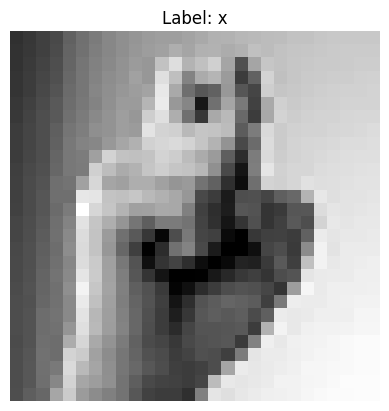

In [7]:
# Randomly select an index
random_index = np.random.randint(0, len(sign_train))

# Extract the label and image data
label = sign_train.iloc[random_index, 0]
letter = letterMapping.get(label)
image_data = sign_train.iloc[random_index, 1:].values
image_data = image_data.reshape(28, 28)  # Reshape the flattened image data to 28x28


# Plot the image
plt.imshow(image_data, cmap='gray')
plt.title(f'Label: {letter}')
plt.axis('off')  # Hide axis
plt.show()

In [8]:
class SignLanguageDataset(Dataset):
    def __init__(self, dataset):

        self.X_data = dataset.iloc[:, 1:785].values
        
        # Normalize the features using RobustScaler
        scaler = RobustScaler()
        self.X_data = scaler.fit_transform(self.X_data)

        # Convert features to PyTorch FloatTensor
        self.X_data = torch.FloatTensor(self.X_data)

        #reshape to needed image shape 
        self.X_data = self.X_data.reshape( -1, 1, 28, 28)

        # Select and transform label column
        self.y_data = torch.LongTensor(dataset.iloc[:, 0].values)
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

train_data = SignLanguageDataset(sign_train)
test_data = SignLanguageDataset(sign_test)

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels= 64, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 64 , kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        #self.dropout= nn.Dropout(0.2)

        self.conv3 = nn.Conv2d(64, 64 , kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)


        self.fc1 = nn.Linear(64 * 3 * 3, 120)
        self.relu4 = nn.ReLU()
        self.drop1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(120, 25)

    def forward(self, out):
            out = self.conv1(out)
            out = self.relu1(out)
            out = self.pool1(out)

            out = self.conv2(out)
            out = self.relu2(out)
            out = self.pool2(out)

            out = self.conv3(out)
            out = self.relu3(out)
            out = self.pool3(out)

            out = out.view(out.size(0), -1)  # Flatten the tensor

            out = self.fc1(out)
            out = self.relu4(out)
            out = self.drop1(out)

            out = self.fc2(out)
            return out
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=SimpleCNN().to(device)

In [ ]:
sweep_configuration = {
    'method': 'random',  # random, grid or bayes
    'name': 'sweep-sign-language',
    'metric': {'goal': 'maximize', 'name': 'weighted_F1_score'},
    'parameters': 
    {
        'batch_size': {'values': [16, 32, 64]},
        'n_epochs': {'values': [10, 20, 25]},
        'learning_rate': {'values': [0.01, 0.001, 0.0001]},
    }
}

In [ ]:
def train_one_epoch(train_loader, model, loss, optimizer):
    loss_epoch = 0.0
    for X_batch, y_batch in train_loader:

        y_pred = model(X_batch)
        batch_train_loss = loss(y_pred, y_batch)
        
        optimizer.zero_grad()
        batch_train_loss.backward()
        optimizer.step()

        loss_epoch += batch_train_loss.item()

    return loss_epoch/len(train_loader)

def evaluate_one_epoch(test_loader, model, loss):
    test_loss = 0.0
    true_test_labels = []
    pred_test_labels = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader: 
            y_test_pred = model(X_test_batch)
            batch_test_loss = loss(y_test_pred, y_test_batch)
            test_loss += batch_test_loss.item()

            predicted = torch.argmax(y_test_pred, 1)
            true_test_labels.extend(y_test_batch.numpy())
            pred_test_labels.extend(predicted.numpy())

    avg_test_loss = test_loss/len(test_loader)
    weighted_F1_score = f1_score(true_test_labels, pred_test_labels, average="weighted")

    return  avg_test_loss, weighted_F1_score


def train():
    wandb.init()
    
    train_loader = DataLoader(dataset=train_data, batch_size=wandb.config.batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=wandb.config.batch_size, shuffle=False)

    model.train()

    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.learning_rate)

    best_weighted_f1 = 0

    for epoch in range(wandb.config.n_epochs): 

        train_loss = train_one_epoch(train_loader, model, loss, optimizer)

        test_loss, weighted_F1_score = evaluate_one_epoch(test_loader, model, loss)

        wandb.log({
            'epoch': epoch, 
            'train_loss': train_loss,
            'test_loss': test_loss,
            'weighted_F1': weighted_F1_score
      })
         
        if (epoch+1)%5==0:
             print(f'Epoch {epoch+1}/{wandb.config.batch_size, wandb.config.learning_rate, wandb.config.n_epochs}, loss {train_loss:.5f}, val_loss {test_loss:.5f}, weighted_F1 {weighted_F1_score:.5f}')
    
    if weighted_F1_score > best_weighted_f1:
            best_weighted_f1 = weighted_F1_score
            torch.save(model.state_dict(), 'best_model.pth')            
            wandb.save('best_model.pth')
    return model
  

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project='machine-learning-project')
wandb.agent(sweep_id, function=train, count=2)
wandb.finish()

Create sweep with ID: qxxe8xjd
Sweep URL: https://wandb.ai/felix-organisation/machine-learning-project/sweeps/qxxe8xjd


wandb: Agent Starting Run: x60qiheo with config:
wandb: 	batch_size: 48
wandb: 	learning_rate: 0.001
wandb: 	n_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 5/(48, 0.001, 5), loss 0.03190, val_loss 0.22878, weighted_F1 0.93669


epoch,▁▃▅▆█
test_loss,█▃▂▁▂
train_loss,█▂▁▁▁
weighted_F1,▁▆▇█▇
epoch,4
test_loss,0.22878
train_loss,0.0319
weighted_F1,0.93669


wandb: Agent Starting Run: 4gl6ovoe with config:
wandb: 	batch_size: 48
wandb: 	learning_rate: 0.001
wandb: 	n_epochs: 5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Epoch 5/(48, 0.001, 5), loss 0.01667, val_loss 0.29218, weighted_F1 0.94954


epoch,▁▃▅▆█
test_loss,▃▃▁▁█
train_loss,█▅▄▁▃
weighted_F1,▃▂▇█▁
epoch,4
test_loss,0.29218
train_loss,0.01667
weighted_F1,0.94954


In [14]:
#Load best model
model.load_state_dict(torch.load("best_model2.pth"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (relu4): ReLU()
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=120, out_features=25, bias=True)
)

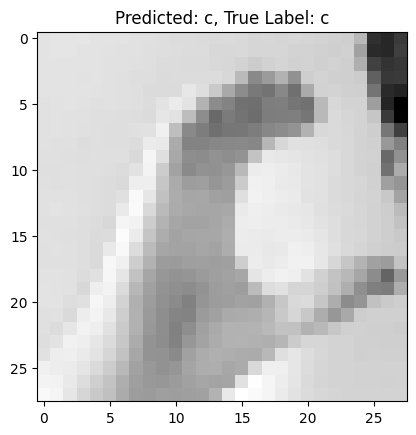

In [15]:
#Test Classification ability of used Model again with random index, but with true and predicted label
random_index = random.randint(0, len(test_data) - 1)
random_image, true_label = test_data[random_index]
random_image = random_image.unsqueeze(0)  # shape: (1, 1, 28, 28)

with torch.no_grad():
    output = model(random_image)
    predicted_label = torch.argmax(output, 1)
    predicted_class = letterMapping[predicted_label.item()]
    true_class = letterMapping[true_label.item()]

    image_to_show = random_image.reshape(28, 28)

plt.imshow(image_to_show, cmap='gray')
plt.title(f'Predicted: {predicted_class}, True Label: {true_class}')
plt.show()

weighted average f1 score: 0.9741143634543064


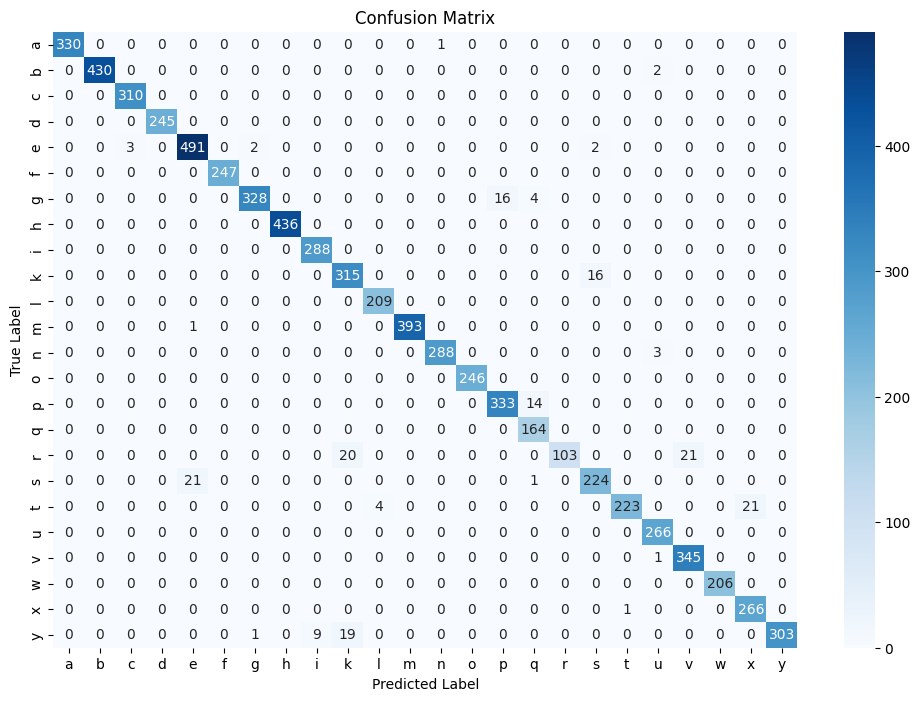

In [16]:
#Visualize Model prediction using confusion matrix
test_loader = DataLoader(dataset=test_data, batch_size=32, shuffle=False)

def evaluate_model_confusion_matrix(test_loader, model):
    true_test_labels = []
    pred_test_labels = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader: 
            y_test_pred = model(X_test_batch)
            predicted = torch.argmax(y_test_pred, 1)
            true_test_labels.extend(y_test_batch.numpy())
            pred_test_labels.extend(predicted.numpy())

    weighted_F1_score = f1_score(true_test_labels, pred_test_labels, average="weighted")

    return weighted_F1_score, true_test_labels, pred_test_labels

f1, y_true, y_pred = evaluate_model_confusion_matrix(test_loader=test_loader, model=model)

print("weighted average f1 score: " + str(f1))


# Creating the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Mapping the confusion matrix labels to letters
letter_mapping = {0: 'a', 1: 'b', 2: 'c', 3: 'd', 4: 'e', 5: 'f', 6: 'g', 7: 'h', 8: 'i', 10: 'k', 11: 'l', 12: 'm', 13: 'n', 14: 'o', 15: 'p', 16: 'q', 17: 'r', 18: 's', 19: 't', 20: 'u', 21: 'v', 22: 'w', 23: 'x', 24: 'y'}
labels = [letter_mapping[i] for i in sorted(letter_mapping.keys())]

# Plotting the confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()